In [80]:
import torch
ckpt = torch.load('/raid/work/ji016/project/2025/mae/output100/pretrain_mae_vit_small_patch16_ep400_optsoap_blr0.0001_skiplessTrue_mimetic2.0_0.6_unetTrue/checkpoint-0.pth',weights_only=False)

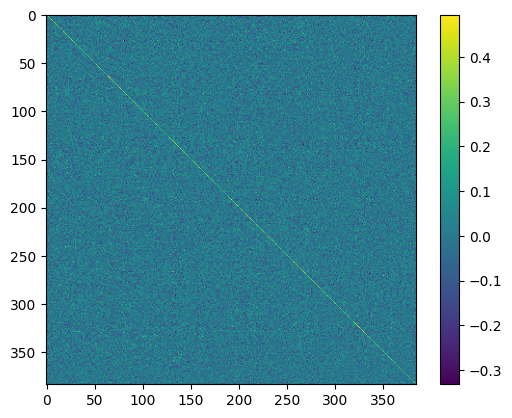

In [81]:
import matplotlib.pyplot as plt
index = 1
k=5
key_to_plot = f'blocks.{index}.attn.qkv.weight'
proj_to_plot = f'blocks.{index}.attn.proj.weight'

qkv_weights = ckpt['model'][key_to_plot]
proj_weights = ckpt['model'][proj_to_plot]
embed_dim = qkv_weights.shape[1]
w_q, w_k, w_v = qkv_weights.chunk(3, dim=0)
plt.imshow((w_q[:,64*k:64*(k+1)]@w_k[:,64*k:64*(k+1)].T).detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

# plt.imshow((w_v@proj_weights).detach().cpu().numpy(), cmap='viridis')
# plt.colorbar()
# plt.show()


In [8]:
torch.linalg.cond(w_q@w_k.T)

tensor(136034.6094, device='cuda:0')

In [ ]:
def get_ortho1(dim: int, device: torch.device = None) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generates two random orthogonal matrices of size dim x dim using PyTorch.
    """
    # Generate the first random matrix and find its orthogonal part via QR decomposition
    random_matrix1 = torch.randn(dim, dim, device=device)
    q1, r1 = torch.linalg.qr(random_matrix1)
    # Enforce a unique Q by making the diagonal of R positive
    q1 = q1 @ torch.diag(-torch.sign(torch.diag(r1)))

    # Generate the second random matrix and find its orthogonal part
    random_matrix2 = torch.randn(dim, dim, device=device)
    q2, r2 = torch.linalg.qr(random_matrix2)
    # Enforce a unique Q by making the diagonal of R positive
    q2 = q2 @ torch.diag(torch.sign(torch.diag(r2)))

    return q1, q2
def get_ortho2(dim: int, device: torch.device = None) -> tuple[torch.Tensor, torch.Tensor]:

    A = torch.randn(dim, dim, device=device)
    U, S, Vh = torch.linalg.svd(A)
    
    return U, Vh
def suo_initialize(m: int, k: int, device: torch.device = 'cuda') -> torch.Tensor:
    """
    Generates an m x k matrix using SUO initialization with PyTorch.
    """
    if m <= k:
        X = torch.randn(m, k, device=device)
        A = X @ X.T # Create the m x m matrix XX^T
        eigenvalues, eigenvectors = torch.linalg.eigh(A)
        inv_sqrt_eigenvalues = eigenvalues.clamp(min=1e-8).rsqrt()
        A_inv_sqrt = eigenvectors @ torch.diag(inv_sqrt_eigenvalues) @ eigenvectors.T
        
        W = A_inv_sqrt @ X

    else: # m > k
        X = torch.randn(k, m, device=device)
        A = X @ X.T 
        eigenvalues, eigenvectors = torch.linalg.eigh(A)
        inv_sqrt_eigenvalues = eigenvalues.clamp(min=1e-8).rsqrt()
        A_inv_sqrt = eigenvectors @ torch.diag(inv_sqrt_eigenvalues) @ eigenvectors.T
        W_intermediate = A_inv_sqrt @ X
        Q = W_intermediate.T
        
        scaling_factor = (m / k) ** 0.5
        W = scaling_factor * Q

    return W

In [27]:
l1, r1 = get_ortho1(64, device='cuda')
l2, r2 = get_ortho2(64, device='cuda')

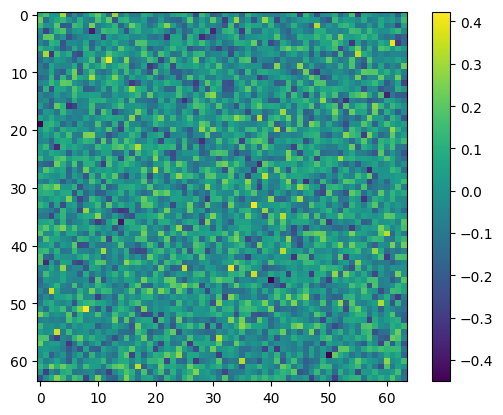

In [28]:
plt.imshow((l1@r1).detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

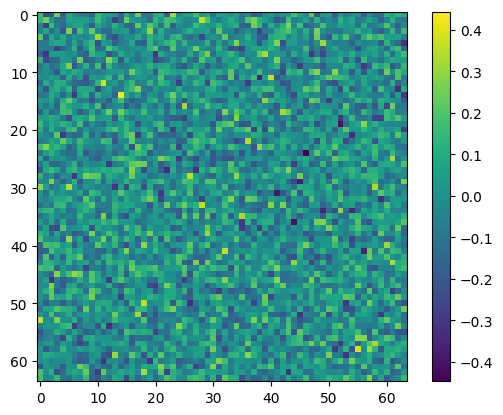

In [29]:
plt.imshow((l2@r2).detach().cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

In [25]:
torch.linalg.cond(l1@r1)
torch.linalg.cond(l2@r2)

tensor(1.0000, device='cuda:0')